## 데이콘 비트코인 가격 예측 - Keras GRU & Bidirectional GRU
런타임 유형 None -> GPU로 변경해서 실험할 것.





In [ ]:
# colab drive mount 
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 폴더 path 설정 및 working directory 변경
folder_path = './drive/MyDrive'
os.chdir(folder_path)


# current working directory 확인
print(os.getcwd())
''' 정상 경로 : /content/drive/My Drive '''


# data uploading folder create
dir_name = 'bitcoin_dataset'

def make_dir(dir_name):
    try:
        # Create target Directory
        os.mkdir(dir_name)
        print("Directory " , dir_name ,  " Created ") 
    except FileExistsError:
        print("Directory " , dir_name ,  " already exists")

# 폴더 생성
make_dir(dir_name)

# 폴더 생성됬는 지 확인 
print(os.listdir())

# 업로드할 디렉토리 변경
os.chdir('./bitcoin_dataset/')

# current working directroy confirm
print(os.getcwd())

/content/drive/MyDrive
Directory  bitcoin_dataset  already exists
['Colab Notebooks', '산갱', 'somethings', '.ipynb_checkpoints', '블로그 방문관련 이슈 조사.gform', '제목 없는 설문지.gform', 'bitcoin_dataset', '인증.png']
/content/drive/MyDrive/bitcoin_dataset


### library import & data upload

In [ ]:
# others
# colab drive mount 
import pandas as pd
import numpy as np
import argparse
import datetime
from copy import deepcopy # Add Deepcopy for args
import pickle 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"GPU 사용 체크 {tf.test.gpu_device_name()}")
seed = 777
np.random.seed(seed)

drive.mount('/content/drive')
# read file
df = pd.read_hdf('/content/drive/My Drive/bitcoin_dataset/merged_data.h5')

Populating the interactive namespace from numpy and matplotlib
GPU 사용 체크 /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### data split
임의적으로 진행함, 우선 200 sample만 가지고 되는지 확인해보려고 함

In [ ]:
train_df = df[df.sample_id < 200]
test_df = df[df.sample_id >= 1203]

# val_df = df[(df.sample_id >= 1000) & (df.sample_id < 1108)]


### data preprocess

In [ ]:
# ====== Generating Dataset ====== #

def open_data_generate(dataframe, col_name, x_frames, y_frames, print_mode = False):

    ''' 설명 생략 '''

    # grouping
    grouped_df = dataframe.groupby('sample_id')
    
    # export unique sample ids
    unique_sample_id_list = grouped_df.sample_id.unique()

    # create new lists
    X, y = list(), list()

    ''' 샘플 하나 선택 loop '''
    for sample_id in unique_sample_id_list:
        
        # get one sample_id in sample list
        temp_sample_id = sample_id.item()

        # get one group by temp_sample_id
        temp_series = grouped_df.get_group(temp_sample_id)[col_name]

        # 한 샘플당 몇 개의 arrset가 나오는 지 확인
        count = 0
        split_length = len(temp_series) - (x_frames + y_frames) + 1
        
        ''' 한 샘플 내 데이터 split loop '''
        for time_idx in range(split_length):
            
            # index 변경
            time_idx += x_frames
            
            # temp_data select
            temp_arr = temp_series[time_idx - x_frames : time_idx + y_frames]

            # get values
            temp_x, temp_y = temp_arr.iloc[:x_frames].values, temp_arr.iloc[x_frames:].values

            # appending
            X.append(temp_x)
            y.append(temp_y)
            
            # counter printing
            count += 1
            if (count == split_length) & (print_mode == True):
                print(f'현재 sample id : {temp_sample_id}')
                print(f'{temp_sample_id}번째 sample의 생성 array수 : {count}')
            
    return np.array(X), np.array(y)

In [ ]:
#print mode = True로 바꾸면 데이터 어떻게 분할되는지 볼 수 있음
x_frames = 60
train_x, train_y = open_data_generate(train_df,col_name ='open', x_frames = x_frames, y_frames = 1, print_mode = False)

In [ ]:

print(
    "데이터 전처리 후 shape\n"
    f'train x shape is {train_x.shape} \n'
    f'train y shape is {train_y.shape}'
)

데이터 전처리 후 shape
train x shape is (288000, 60) 
train y shape is (288000, 1)


### data reshaping

In [ ]:

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1  #open 데이터만 가지고 함.
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))


### modeling & prediction

#### 1. simple GRU model

In [ ]:
model = keras.models.Sequential(
    [
     keras.layers.GRU(units = 50, input_shape=(x_frames, 1)),
     keras.layers.Dense(1)
    ]
)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 50)                7950      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


#### 2. Bidirectional GRU model

In [ ]:
model = keras.models.Sequential(
    [
     keras.layers.Bidirectional(layers.GRU(units = 50, return_sequences =True), input_shape=(x_frames, 1)), 
     keras.layers.GRU(units = 50),
     keras.layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 60, 100)           15900     
_________________________________________________________________
gru_5 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_x, train_y, epochs=10, verbose=1)

Epoch 1/10
9000/9000 [==============================] - 72s 8ms/step - loss: 2.7725e-06
Epoch 2/10
9000/9000 [==============================] - 72s 8ms/step - loss: 2.7467e-06
Epoch 3/10
9000/9000 [==============================] - 73s 8ms/step - loss: 2.8116e-06
Epoch 4/10
9000/9000 [==============================] - 73s 8ms/step - loss: 2.7376e-06
Epoch 5/10
9000/9000 [==============================] - 73s 8ms/step - loss: 2.6750e-06
Epoch 6/10
9000/9000 [==============================] - 75s 8ms/step - loss: 2.6862e-06
Epoch 7/10
9000/9000 [==============================] - 73s 8ms/step - loss: 2.6720e-06
Epoch 8/10
9000/9000 [==============================] - 74s 8ms/step - loss: 2.6607e-06
Epoch 9/10
9000/9000 [==============================] - 74s 8ms/step - loss: 2.6689e-06
Epoch 10/10
9000/9000 [==============================] - 73s 8ms/step - loss: 2.6301e-06


### model save & load

In [ ]:
# 모델 저장
model_path = './Bidirectional_GRU_model.h5' # 모델명 알아서 적고, 확장자는 .h5
model.save(model_path) 

# 모델 로드
model = keras.models.load_model(model_path)

### prediction & plotting

In [ ]:
def targetframes_predict(model = model,dataframe = test_df, test_id = 1207, x_frames = 60 , target_len = 120):

    # list 만들고, 마지막 데이터 30개 추출
    y_pred_list = list()
    y_true_list = dataframe[dataframe.sample_id == test_id].reset_index(drop=True).open[1380:].values
    
    x_input = dataframe[dataframe.sample_id == test_id].reset_index(drop=True).open[1380 - x_frames :1380].values

    for i in range(target_len):

        yhat = model.predict(x_input.reshape((1, x_frames, 1)), verbose=0)
        
        # list append
        y_pred = round(yhat.item(), 8)
        y_pred_list.append(y_pred)

        # exchage input data
        x_input = np.append(x_input, y_pred)
        x_input = np.delete(x_input, 0)


    return np.array(y_pred_list), np.array(y_true_list)


In [ ]:
# test_df의 test_id = 1207이 실제 데이터에서의 7657 임, target_len는 반복 예측해야 할 구간 길이
y_pred_arr, y_true_arr = targetframes_predict(model = model, dataframe = test_df, test_id = 1207, x_frames = x_frames , target_len = 120)

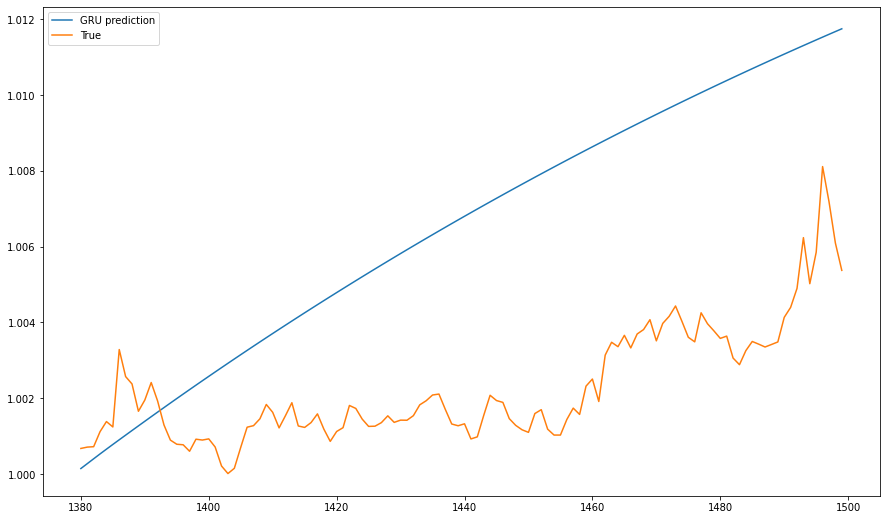

In [ ]:
# 모델 결과

plt.plot(np.arange(1380, 1380+120), y_pred_arr, label = 'GRU prediction')
plt.plot(np.arange(1380, 1380+120), y_true_arr, label = 'True')

plt.legend()
plt.show()

In [ ]:
# MSE 에러 계산
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true_arr, y_pred_arr))

2.3779854908904886e-05
